# Dealing with Duplicate Rates

Sometimes we combine multiple sources of rates into a `RateCollection` or network, and we run the risk of
having the same rate sequence duplicated, even though the rate itself may be different (i.e., a different
source or tabulated vs. ReacLib).

In [1]:
import pynucastro as pyna

In [2]:
rl = pyna.ReacLibLibrary()
wl = pyna.TabularLibrary()

Let's create a set of nuclei that can describe basic C burning

In [3]:
nuclei = ["c12", "o16", "ne20",
          "na23", "mg23", "mg24",
          "p", "n", "a"]

We'll pull rates in both from the ReacLib library and from our tabulated weak rates

In [4]:
lib = rl.linking_nuclei(nuclei) + wl.linking_nuclei(nuclei)

If we try to create a network or `RateCollection` now, it will fail:

In [5]:
rc = pyna.RateCollection(libraries=[lib])

/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/pynucastro/networks/rate_collection.py:573: UserWarning: ReacLib neutron decay rate (<n_to_p_weak_wc12>) does not account for degeneracy at high densities. Consider using tabular rate from Langanke.
  warnings.warn(msg)


RateDuplicationError: Duplicate rates found

We see that we get a `RateDuplicationError` because one or more rates has a duplicate.

We can find the duplicates using the `find_duplicate_links()` method.  This will return a list of tuples of rates that all provide the same link.

In [6]:
lib.find_duplicate_links()

[[n ⟶ p + e⁻ + 𝜈, n ⟶ p + e⁻ + 𝜈],
 [Mg23 ⟶ Na23 + e⁺ + 𝜈, Mg23 + e⁻ ⟶ Na23 + 𝜈]]

We see that the neutron decay and the decay of ${}^{23}\mathrm{Mg}$ are both duplicated.  Let's see if we can learn more:

In [7]:
for n, p in enumerate(lib.find_duplicate_links()):
    print(f"dupe {n}:")
    print(f"   rate 1: {p[0]} ({type(p[0])})")
    print(f"   rate 2: {p[1]} ({type(p[1])})")

dupe 0:
   rate 1: n ⟶ p + e⁻ + 𝜈 (<class 'pynucastro.rates.rate.ReacLibRate'>)
   rate 2: n ⟶ p + e⁻ + 𝜈 (<class 'pynucastro.rates.rate.TabularRate'>)
dupe 1:
   rate 1: Mg23 ⟶ Na23 + e⁺ + 𝜈 (<class 'pynucastro.rates.rate.ReacLibRate'>)
   rate 2: Mg23 + e⁻ ⟶ Na23 + 𝜈 (<class 'pynucastro.rates.rate.TabularRate'>)


In this case, we see that one is a `ReacLibRate` and the other is a `TabularRate`.
For the tabular rates, we take the approach that the sequences:

The first duplicate is neutron decay.  ReacLib simply has the decay constant, with no density or temperature
dependence.  The tabulated rate in this case comes from the Langanke paper and is accurate at high densities / temperatures when degeneracy effects are important.

For the second rate, note that in the `TabularRate` we combine the rates:

$$(Z, A) \rightarrow (Z -1, A) + e^+ + \nu_e$$

$$(Z, A) + e^- \rightarrow (Z - 1, A) + \bar{\nu}_e$$

into a single effective rate.  This means that our `TabularRate` version
of the ${}^{23}\mathrm{Mg}$ decay will contain both the $\beta+$ decay and electron capture.  Furthermore, the tabular rates have both the density and temperature dependence, and thus should be preferred to the `ReacLibRates` when we have a duplicate.

Here we loop over the duplicates and store the rates (the ReacLib versions) that we wish to *remove* in a list

In [8]:
rates_to_remove = []
for pair in lib.find_duplicate_links():
    for r in pair:
        if isinstance(r, pyna.rates.ReacLibRate):
            rates_to_remove.append(r)

Now we remove the duplicates from the list

In [9]:
for r in rates_to_remove:
    lib.remove_rate(r)

Finally, we can make the `RateCollection` without error:

In [10]:
rc = pyna.RateCollection(libraries=[lib])

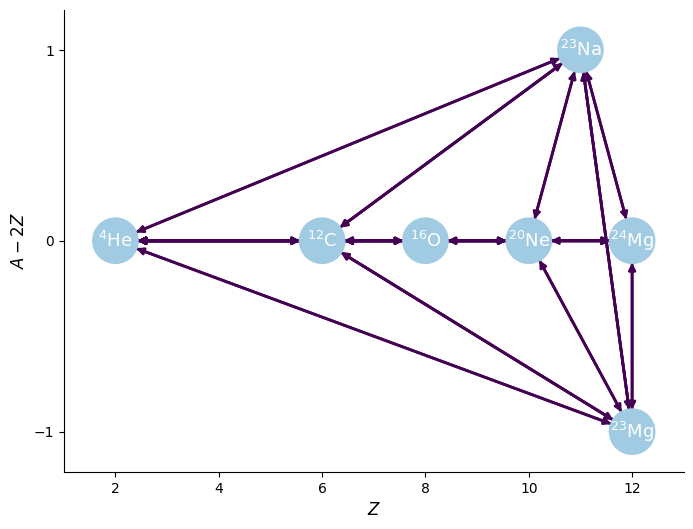

In [11]:
fig = rc.plot(rotated=True)